# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [8]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.036520014904625864
 0.7837730945499357  
 0.39741011854927843 
 0.5642561210147754  
 0.3894514864876455  
 0.25469870848914256 
 0.3304152156976061  
 0.8003840143957461  
 0.5189687428825449  
 0.5829228864096077  
 0.08527806992137266 
 0.9550023741276914  
 0.7000110772620065  
 ⋮                   
 0.5584022774552462  
 0.06812651526787139 
 0.22446071336057316 
 0.8901165067751213  
 0.3414307398374159  
 0.17703676375761668 
 0.6879126791733898  
 0.0397335079684169  
 0.5196512215063718  
 0.7008855078348526  
 0.99313675709417    
 0.49638855800395687 

In [9]:
sum(a)

4.997542387813178e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [10]:
@time sum(a)

  0.004843 seconds (5 allocations: 176 bytes)


4.997542387813178e6

In [11]:
@time sum(a)

  0.005121 seconds (5 allocations: 176 bytes)


4.997542387813178e6

In [12]:
@time sum(a)

  0.005045 seconds (5 allocations: 176 bytes)


4.997542387813178e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [13]:
using Pkg
# Pkg.add("BenchmarkTools")

In [14]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [15]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [16]:
c_sum(a)

4.9975423878132645e6

In [17]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [18]:
c_sum(a) - sum(a)

8.66129994392395e-8

In [19]:
≈  # alias for the `isapprox` function

isapprox (generic function with 8 methods)

In [20]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [21]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.272 ms (0.00% GC)
  median time:      13.507 ms (0.00% GC)
  mean time:        13.491 ms (0.00% GC)
  maximum time:     14.599 ms (0.00% GC)
  --------------
  samples:          371
  evals/sample:     1

In [22]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.272206 msec


In [23]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 12.2722

In [24]:
using Plots
gr()

Plots.GRBackend()

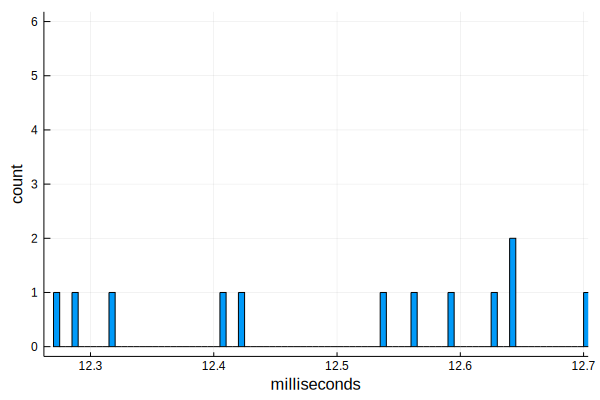

In [25]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")
# # 2. C with -ffast-math

In [26]:
# If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [27]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.566 ms (0.00% GC)
  median time:      7.207 ms (0.00% GC)
  mean time:        7.236 ms (0.00% GC)
  maximum time:     9.739 ms (0.00% GC)
  --------------
  samples:          691
  evals/sample:     1

In [28]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

6.566499

# 3. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [29]:
#Pkg.add("PyCall")
using PyCall

In [30]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [31]:
pysum(a)

4.9975423878132645e6

In [32]:
pysum(a) ≈ sum(a)

true

In [33]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     1.580 s (0.00% GC)
  median time:      1.616 s (0.00% GC)
  mean time:        1.619 s (0.00% GC)
  maximum time:     1.662 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [34]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 12.2722
  "Python built-in" => 1579.92
  "C -ffast-math"   => 6.5665

# 4. Python: `numpy`

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [ ]:
# using Pkg; Pkg.add("Conda")
using Conda

In [37]:
#Conda.add("numpy")

In [38]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[38]:1
└ @ Core In[38]:1


BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     4.302 ms (0.00% GC)
  median time:      4.789 ms (0.00% GC)
  mean time:        4.918 ms (0.00% GC)
  maximum time:     6.309 ms (0.00% GC)
  --------------
  samples:          1015
  evals/sample:     1

In [39]:
numpy_sum(a)

4.997542387813177e6

In [40]:
numpy_sum(a) ≈ sum(a)

true

In [41]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 12.2722
  "Python numpy"    => 4.30194
  "Python built-in" => 1579.92
  "C -ffast-math"   => 6.5665

# 5. Python, hand-written

In [42]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f942a6b1950>

In [43]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     1.851 s (0.00% GC)
  median time:      1.893 s (0.00% GC)
  mean time:        1.902 s (0.00% GC)
  maximum time:     1.962 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

In [44]:
sum_py(a)

4.9975423878132645e6

In [45]:
sum_py(a) ≈ sum(a)

true

In [47]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 12.2722
  "Python numpy"        => 4.30194
  "Python hand-written" => 1850.67
  "Python built-in"     => 1579.92
  "C -ffast-math"       => 6.5665

# 6. Julia (built-in)

## Written directly in Julia, not in C!

In [48]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:652

In [49]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.898 ms (0.00% GC)
  median time:      4.318 ms (0.00% GC)
  mean time:        4.434 ms (0.00% GC)
  maximum time:     6.868 ms (0.00% GC)
  --------------
  samples:          1126
  evals/sample:     1

In [52]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 12.2722
  "Python numpy"        => 4.30194
  "Python hand-written" => 1850.67
  "Python built-in"     => 1579.92
  "Julia built-in"      => 3.89754
  "C -ffast-math"       => 6.5665

# 7. Julia (hand-written)

In [53]:
function mysum(A)
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [54]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.742 ms (0.00% GC)
  median time:      13.658 ms (0.00% GC)
  mean time:        13.702 ms (0.00% GC)
  maximum time:     15.192 ms (0.00% GC)
  --------------
  samples:          365
  evals/sample:     1

In [55]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "C"                   => 12.2722
  "Python numpy"        => 4.30194
  "Julia hand-written"  => 12.742
  "Python hand-written" => 1850.67
  "Python built-in"     => 1579.92
  "Julia built-in"      => 3.89754
  "C -ffast-math"       => 6.5665

# 8. Julia (hand-written w. simd)

In [56]:
function mysum_simd(A)
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [57]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.933 ms (0.00% GC)
  median time:      4.385 ms (0.00% GC)
  mean time:        4.495 ms (0.00% GC)
  maximum time:     5.881 ms (0.00% GC)
  --------------
  samples:          1111
  evals/sample:     1

In [58]:
mysum_simd(a)

4.997542387813175e6

In [59]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia hand-written simd" => 3.9326
  "C"                       => 12.2722
  "Python numpy"            => 4.30194
  "Julia hand-written"      => 12.742
  "Python hand-written"     => 1850.67
  "Python built-in"         => 1579.92
  "Julia built-in"          => 3.89754
  "C -ffast-math"           => 6.5665

# Summary

In [62]:
length(a)

10000000

In [60]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............3.9
Julia hand-written simd.....3.9
Python numpy................4.3
C -ffast-math...............6.6
C..........................12.3
Julia hand-written.........12.7
Python built-in..........1579.9
Python hand-written......1850.7
